# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Steps

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample will be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation
We will begin by loading in necessary libraries, then we will read in our data. We will view general information and then resample our data by one hour. We will group them together by the sum, as we are interested in the total number of taxi orders. 

In [1]:
import pandas as pd# Loading all the libraries
import numpy as np
import math as mt
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
try:  #reading in data using a try-except clause
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    print("File not found.")

In [4]:
data.info() #viewing general information

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
data.head() #taking a look at the first few rows

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
data = data.resample('1H').sum() #resampling data by one hour

In [7]:
data.head() #viewing new data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [8]:
data.describe() #viewing statistical information on the resampled dataset

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


## Analysis
Now we will take a closer look at our data to see if there are any trends we can identify.

<AxesSubplot:xlabel='datetime'>

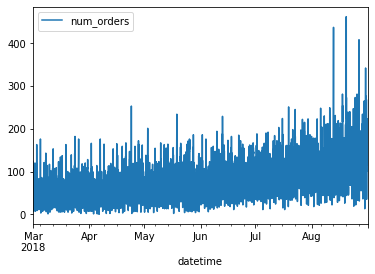

In [9]:
data.plot() #viewing a plot of data

From this graph, we can also see there tend to be a linear trend upwards towards the later months. This could be due to more people traveling in the fall, or perhaps due to colder temperatures. Further investigation would be needed in order to confirm what is causing this. 

Text(0.5, 1.0, 'Residuals')

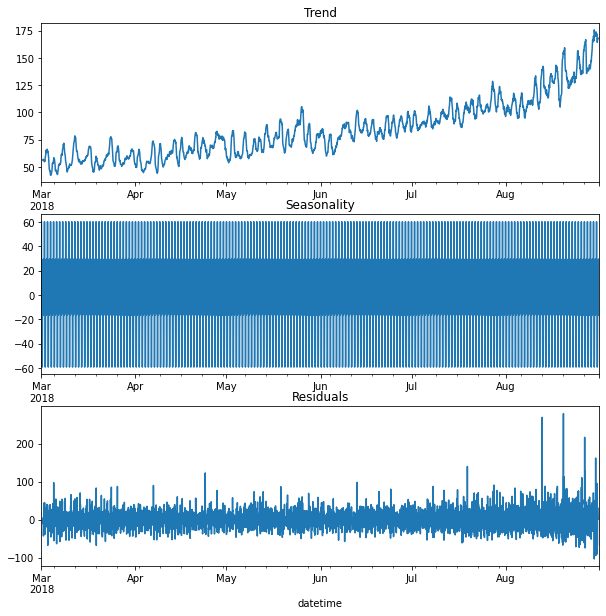

In [10]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(10, 10))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

Since we can see that the graph of seasonality is difficult to fully visualize, we will select a sample to view more closely.

<AxesSubplot:xlabel='datetime'>

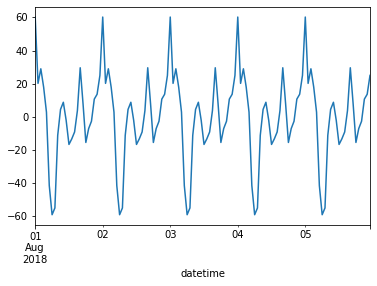

In [11]:
decomp = decomposed.seasonal['2018-08-01':'2018-08-05']
decomp.plot()

We can see that we have an amplitude of 120, and that the cycle appears to repeat daily. 

<AxesSubplot:xlabel='datetime'>

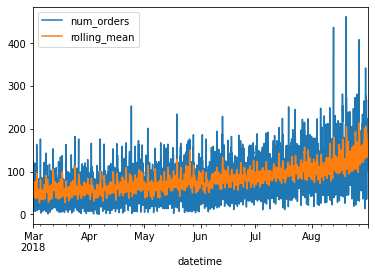

In [12]:
data['rolling_mean'] = data.rolling(10).mean() #viewing rolling mean of our data
data.plot()

Viewing our rolling mean graph and trend graph, it is even more apparent that there appears to be a linear increase in taxi orders across the months. This leads us to believe linear regression will serve our purpose best, but we will still train several models in order to provide the best one. 

## Training

We will begin by creating features to train with by extracting our date and time information from our indexes. We will also add our rolling mean and lag.

In [13]:
def make_features(data, max_lag, rolling_mean_size): #creating features to train our model
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift(1).rolling(rolling_mean_size).mean()

make_features(data, 24, 8)

Now we will split our data into train, valid and test sets. Then we will define the function for root mean squared error, which will be used as a scoring metric for our models.

In [14]:
data = data.dropna() #dropping our created nan values
features= data.drop(columns= ['num_orders']) #naming features and targets
target = data['num_orders'] 
#splitting data into train, valid, test sets - 80% train and 10% valid and test
features_train, features_rem, target_train, target_rem = train_test_split(features,target, train_size=0.8, shuffle = False)
features_valid, features_test, target_valid, target_test = train_test_split(features_rem,target_rem, test_size=0.5, shuffle = False)

In [15]:
print(target_train.index.min(), target_train.index.max()) #ensuring split correctly
print(target_valid.index.min(), target_valid.index.max())
print(target_test.index.min(), target_test.index.max())

2018-03-02 00:00:00 2018-07-26 08:00:00
2018-07-26 09:00:00 2018-08-13 15:00:00
2018-08-13 16:00:00 2018-08-31 23:00:00


In [16]:
def rmse(target, predict): #defining root mean squared error as a metric for grading our models
    return np.sqrt(mean_squared_error(target, predict))

### Linear Regression
We will begin by fitting our linear regression model; since this model does not greatly benefit from hyperparameter tuning we will solely fit it in this step. 

In [17]:
model_LR = LinearRegression() # training linear regression model
model_LR.fit(features_train, target_train)

LinearRegression()

### Decision Tree
Next, we will train our Decision Tree model, and tune the hyperparameter of max_depth.

In [18]:
min_list = [] #tuning hyperparameter of max_depth
for depth in range(1, 6):
    model = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)   
    predictions_valid = model.predict(features_valid)
    min_list.append(rmse(target_valid, predictions_valid))
min_value = min(min_list)
max_depth_number = min_list.index(min_value) +1
print(max_depth_number)

5


In [19]:
model_tree = DecisionTreeRegressor(random_state=12345, max_depth=3) #fitting our model
model_tree.fit(features_train, target_train)

DecisionTreeRegressor(max_depth=3, random_state=12345)

### Random Forest
Finally, we will train our Random Forest model, and will tune the hyperparameters of n_estimators and max_depth.

In [20]:
min_list = [] # tuning n_estimators hyperparameter
for n_estimators in range(1, 10):
    model = RandomForestRegressor(random_state=12345, n_estimators=n_estimators)
    model.fit(features_train, target_train)   
    predictions_valid = model.predict(features_valid)
    min_list.append(rmse(target_valid, predictions_valid))
min_value = min(min_list)
n_estimators_number = min_list.index(min_value) +1
print(n_estimators_number)

9


In [21]:
min_list = [] #tuning max_depth hyperparameter
for depth in range(1, 6):
    model = RandomForestRegressor(random_state=12345, max_depth=depth, n_estimators=9)
    model.fit(features_train, target_train)   
    predictions_valid = model.predict(features_valid)
    min_list.append(rmse(target_valid, predictions_valid))
min_value = min(min_list)
max_depth_number = min_list.index(min_value) +1
print(max_depth_number)

5


In [22]:
model_forest = RandomForestRegressor(random_state=12345, n_estimators=9, max_depth=4) #fitting the model
model_forest.fit(features_train, target_train)

RandomForestRegressor(max_depth=4, n_estimators=9, random_state=12345)

## Testing
Now we will move onto our final section, testing. We will utilize the RMSE value to score our models. We need to have a model with a value lower than 48.

### Baseline Comparison
First, we will establish a baseline for which to compare our models. This baseline will predict the value based on the previous value.

In [23]:
pred_previous = target_test.shift(periods=1)
pred_previous[0] = target_valid[-1]
print("RMSE:", rmse(target_test, pred_previous))

RMSE: 58.881776776551476


### Linear Regression

In [24]:
LR_predictions = model_LR.predict(features_test)  #creating predictions
print("RMSE:", rmse(target_test, LR_predictions)) #finding test value 

RMSE: 46.17282778300398


### Decision Tree

In [25]:
tree_predictions = model_tree.predict(features_test) #creating predictions
print("RMSE:", rmse(target_test, tree_predictions)) #finding test value 

RMSE: 62.9975374934335


### Random Forest

In [26]:
forest_predictions = model_forest.predict(features_test) #creating predictions
print("RMSE:", rmse(target_test, forest_predictions)) #finding test value 

RMSE: 63.389975154282986


As expected, we can see that our Linear Regression model performed the best, returning an RMSE value of 46, which is acceptable for our goals. This would be the model we would utilize for our clients to utilize.

## Conclusion

In this project, we utilized time series data to create a model that would predict peak hours for taxi services. We resampled our data by the hour to find the total number of orders. We then examined our data and removed unnecessary outliers. We created features for our model by utilizing our date time indexes and calculated rolling mean. Then we tuned hyperparameters for several models and fitted them to our data. We found that our Linear Regression model performed best based on our scoring method of root mean squared error. This would be the model we would recommend to our clients. 